In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import corner_harris
from PIL import Image
import matplotlib.image as mpimg
from testing_anms import testing_anms
sift = cv2.xfeatures2d.SIFT_create()
from corner_detector import corner_detector
from skimage.feature import corner_harris
import matplotlib.image as mpimg
from scipy import spatial
from skimage.feature import peak_local_max

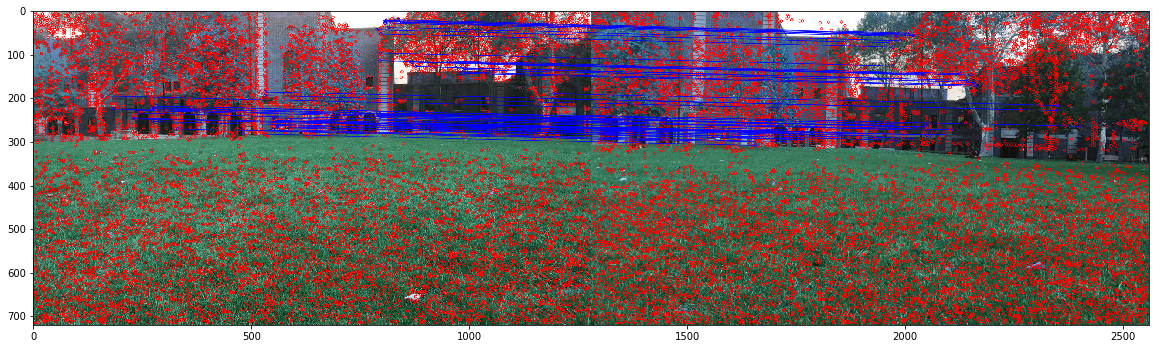

In [53]:
img_1_cv = cv2.imread("left.jpg")
img_2_cv = cv2.imread("right.jpg")
queryImage=cv2.imread("left.jpg",0)
trainingImage=cv2.imread("middle.jpg",0)#读取要匹配的灰度照片
# queryImage = cv2.normalize(query, None, 0, 255, cv2.NORM_MINMAX)
# trainingImage = cv2.normalize(training, None, 0, 255, cv2.NORM_MINMAX)
sift=cv2.xfeatures2d.SIFT_create()#创建sift检测器
kp1, des1 = sift.detectAndCompute(queryImage,None)
kp2, des2 = sift.detectAndCompute(trainingImage,None)
#设置Flannde参数
FLANN_INDEX_KDTREE=0
indexParams=dict(algorithm=FLANN_INDEX_KDTREE,trees=5)
searchParams= dict(checks=50)
flann=cv2.FlannBasedMatcher(indexParams,searchParams)
matches=flann.knnMatch(des1,des2,k=2)
#设置好初始匹配值
matchesMask=[[0,0] for i in range (len(matches))]
for i, (m,n) in enumerate(matches):
	if m.distance< 0.3*n.distance: #舍弃小于0.5的匹配结果
		matchesMask[i]=[1,0]
drawParams=dict(matchColor=(0,0,255),singlePointColor=(255,0,0),matchesMask=matchesMask,flags=0) #给特征点和匹配的线定义颜色
resultimage=cv2.drawMatchesKnn(img_1_cv,kp1,img_2_cv,kp2,matches,None,**drawParams) #画出匹配的结果
plt.imshow(resultimage,),plt.show()
plt.imsave('./FLANN.jpg',resultimage)


In [6]:
def helper(x,y):
    x = x.reshape(x.shape[0],1)
    y = y.reshape(y.shape[0],1)
    xy = np.concatenate((x, y), axis=1)
    keypoints = [cv2.KeyPoint(x[0], x[1], 1) for x in xy]
    return xy,keypoints

In [7]:
# SIFT feature descriptor

# kp_1, des_1 = sift.detectAndCompute(gray_1,None)
# kp_2, des_2 = sift.detectAndCompute(gray_2,None)
# pts_1 = np.asarray([[p.pt[0], p.pt[1]] for p in kp_1])
# pts_2 = np.asarray([[p.pt[0], p.pt[1]] for p in kp_2])

def feat_desc_SIFT(img,keypoints):
    kp, des= sift.compute(img,keypoints)
#     for i in range(0, des.shape[0]):
#         amax = np.amax(des[i])
#         amin = np.amin(des[i])
#         des[i] = (des[i]-amin) / (amax-amin)
    return des

In [43]:
# FLANN_Matcher 
def FLANN_Matcher(img_1,img_2,descs_1,descs_2,keypoints_1,keypoints_2,xy_1,xy_2,suffix):
    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    matches = flann.knnMatch(descs_1,descs_2,k=2)
    
    match = np.zeros((descs_1.shape[0],1))
    match.fill(-1)
    
    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]
    good_without_list = []

    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.6*n.distance:
            matchesMask[i]=[1,0]
            good_without_list.append(m)
            
    draw_params = dict(matchColor = (0,255,0),
                       singlePointColor = (255,0,0),
                       matchesMask = matchesMask,
                       flags = 0)

    img3 = cv2.drawMatchesKnn(img_1,keypoints_1,img_2,keypoints_2,matches,None,**draw_params)
    plt.rcParams['figure.figsize'] = [20, 20]
    plt.imshow(img3,),plt.show()
    plt.imsave('./SIFT_Decriptor_900.jpg',img3)
    
    list_kp1 = [keypoints_1[mat.queryIdx].pt for mat in good_without_list] 
    list_kp2 = [keypoints_2[mat.trainIdx].pt for mat in good_without_list]

    for i in range(len(list_kp1)):
        col_kp1, row_kp1 = list_kp1[i]
        col_kp2, row_kp2 = list_kp2[i]
        idx = np.argwhere((xy_1[:,0] == col_kp1) & (xy_1[:,1]== row_kp1)).flatten()
        val = np.argwhere((xy_2[:,0] == col_kp2) & (xy_2[:,1]== row_kp2)).flatten()
        match[idx[0]] = val[0]
        
    idx_1 = np.argwhere(match > -1)
    idx_1 = idx_1.flatten()
    idx_2 = np.take(match, idx_1)
    idx_2 = idx_2.astype(int)
    print(idx_2)
    draw_x1 = x_1[idx_1]
    draw_y1 = y_1[idx_1]
    draw_x2 = x_2[idx_2]
    draw_y2 = y_2[idx_2]
    print('Saving to ', './data/draw_x1_' + suffix)
    np.save('./data/draw_x1_' + suffix, draw_x1)
    np.save('./data/draw_y1_' + suffix, draw_y1)
    np.save('./data/draw_x2_' + suffix, draw_x2)
    np.save('./data/draw_y2_' + suffix, draw_y2)
    print(draw_x1)
    print(draw_y1)
    return match


In [44]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

In [45]:
img_1 = mpimg.imread("right.jpg")
gray_1 = rgb2gray(img_1)
img_2 = mpimg.imread("middle.jpg")
gray_2 = rgb2gray(img_2)
cimg_1 = corner_detector(gray_1)
cimg_2 = corner_detector(gray_2)
x_1,y_1,r_max_1 = testing_anms(cimg_1,900)
x_2,y_2,r_max_2 = testing_anms(cimg_2,900)
# xy_1,keypoints_1 = helper(x_1,y_1)
# xy_2,keypoints_2 = helper(x_2,y_2)
# # des_1 = feat_desc_DoG(gray_1,x_1,y_1)
# # des_2 = feat_desc_DoG(gray_2,x_1,y_1)
# descs_1 = feat_desc_SIFT(gray_1,keypoints_1)
# descs_2 = feat_desc_SIFT(gray_2,keypoints_2)
# match = FLANN_Matcher(descs_1,descs_2,keypoints_1,keypoints_2,xy_1,xy_2)
# print(match.shape)

(900,)
(900, 128)


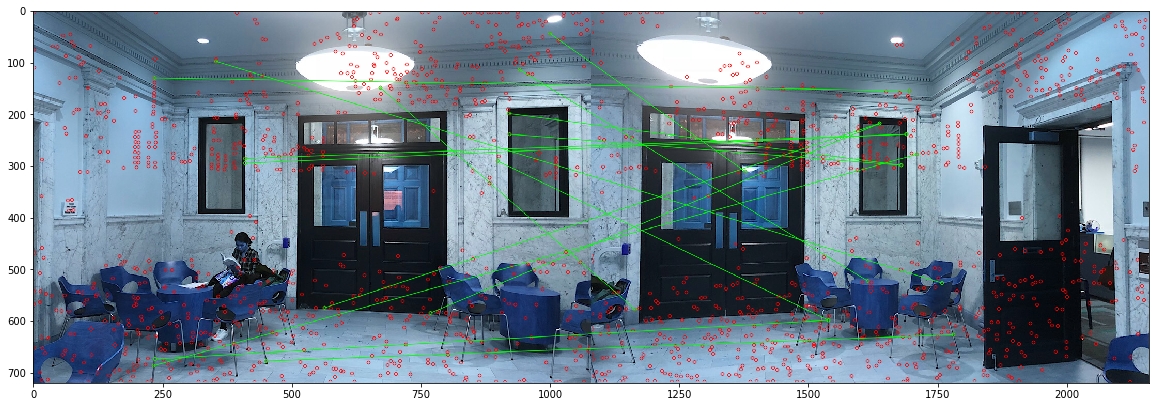

[410  -1 499  -1 489  -1 200  -1 589  -1 384  -1 384  -1 305  -1 630  -1
 305  -1 283  -1 283  -1 630  -1 698  -1 353  -1]
Saving to  ./data/draw_x1_SIFT
[1000  670  354  670  941  670  235  670  672  670  921  670  922  670
  410  670  899  670  410  670  564  670  769  670  236  670  451  670
  233  670]
[ 43   1  97   1 113   1 129   1 148   1 198   1 238   1 285   1 290   1
 294   1 574   1 584   1 673   1 677   1 686   1]
[[ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ -1.]
 

In [47]:
img_1_cv = cv2.imread("our_left.jpg")
img_2_cv = cv2.imread("our_right.jpg")
gray_1_cv = cv2.imread("our_left.jpg",0)
gray_2_cv = cv2.imread("our_right.jpg",0)
x_1 = np.asarray(x_1)
y_1 = np.asarray(y_1)
x_2 = np.asarray(x_2)
y_2 = np.asarray(y_2)
print(x_1.shape)
xy_1,keypoints_1 = helper(x_1,y_1)
xy_2,keypoints_2 = helper(x_2,y_2)
# print(keypoints_1)
# kp, des= sift.compute(img_1,keypoints_1)
# des_1 = feat_desc_DoG(gray_1,x_1,y_1)
# des_2 = feat_desc_DoG(gray_2,x_1,y_1)
descs_1 = feat_desc_SIFT(gray_1_cv,keypoints_1)
descs_2 = feat_desc_SIFT(gray_2_cv,keypoints_2)
print(descs_1.shape)
match = FLANN_Matcher(img_1_cv,img_2_cv,descs_1,descs_2,keypoints_1,keypoints_2,xy_1,xy_2,'SIFT')
print(match)

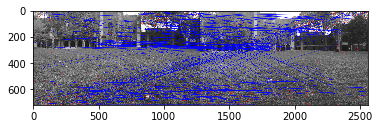

In [14]:
queryImage=cv2.imread("left.jpg",0)
trainingImage=cv2.imread("middle.jpg",0)#读取要匹配的灰度照片
# # queryImage = cv2.normalize(query, None, 0, 255, cv2.NORM_MINMAX)
# # trainingImage = cv2.normalize(training, None, 0, 255, cv2.NORM_MINMAX)
# sift=cv2.xfeatures2d.SIFT_create()#创建sift检测器
# kp1, des1 = sift.detectAndCompute(queryImage,None)
# kp2, des2 = sift.detectAndCompute(trainingImage,None)
#设置Flannde参数
FLANN_INDEX_KDTREE=0
indexParams=dict(algorithm=FLANN_INDEX_KDTREE,trees=5)
searchParams= dict(checks=50)
flann=cv2.FlannBasedMatcher(indexParams,searchParams)
matches=flann.knnMatch(descs_1,descs_2,k=2)
#设置好初始匹配值
matchesMask=[[0,0] for i in range (len(matches))]
for i, (m,n) in enumerate(matches):
	if m.distance< 0.9*n.distance: #舍弃小于0.5的匹配结果
		matchesMask[i]=[1,0]
drawParams=dict(matchColor=(0,0,255),singlePointColor=(255,0,0),matchesMask=matchesMask,flags=0) #给特征点和匹配的线定义颜色
resultimage=cv2.drawMatchesKnn(queryImage,keypoints_1,trainingImage,keypoints_2,matches,None,**drawParams) #画出匹配的结果
plt.imshow(resultimage,),plt.show()
plt.imsave('./FLANN.jpg',resultimage)
